
> ⚠️ **Warning:** This notebook file is paired to a .py file with the same name, such that we can cleanly import the functionality from other notebooks. This is done using the facilities of the jupytext package. The cells in this notebook that are only meant as "demonstration" are marked with the cell tag "active-ipynb", which causes the jupytext synchronization command to ignore these when syncing to the .py file. This is our current way of doing "literate programming" with jupyter notebooks.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imitation Learning

Optional further refinements:
- cache solved train instances across multiple instances of ImitationLearning class
- separately measure time needed to solve train instances

In [ ]:
from exact import solve

from mdp import SingleScheduleEnv, HorizonObservationWrapper, HorizonRollingWrapper

import torch
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from tqdm import tqdm

class ImitationLearning:

    def train(self, gen):
        # 1. obtain expert data
        # this involves computing near-optimal solutions by solving MILPs,
        # which becomes very expensive for larger instances
        # (so we might share this step, if we want to test multiple 
        #  configurations of imitation learning)
        N_train = 1
        states, actions = self._generate_expert_demonstration(gen, N_train)

        # 2. fit model to expert data state-action pairs
        # TODO: apply appropriate transformation of observation/action wrappers

        total_steps = 500
        batch_size = 20

        train_set = TensorDataset(torch.vstack(states), torch.vstack(actions))
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

        learning_rate = 5e-4
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_losses = []
        step = 0
        with tqdm(total=total_steps, desc=f"training", leave=False) as pbar:
            while True:
                for s, a in train_loader:
                    # perform a single training step
                    model.train()
                    optimizer.zero_grad()
                    loss = binary_cross_entropy_with_logits(model(s), a)
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                    step += 1
                    pbar.update(1)

                    if step >= total_steps: break # ...out of inner loop
                if step >= total_steps: break # ...out of outer loop

    def eval(self, gen):
        return 1

    def _generate_expert_demonstration(self, gen, N):
        states, actions = [], []
        for _ in tqdm(range(N), desc="Generating/solving train instances"):
            # 1a. generate training instance
            s = gen()

            # 1b. compute optimal solution
            s.solve()

            # 1c. compute route order ("eta")
            ix = s.vehicle_indices
            y = s.opt.y
            vehicle_order = s.opt.vehicle_order        
            route_order = s.opt.route_order

            # 1c. play optimal route order on the MDP to extract expert demonstration
            env = SingleScheduleEnv(instance_generator=lambda: s)
            state, _ = env.reset()
            done = False
            eta = iter(route_order) # replay optimal route order
            while not done:
                # NOTE: currently just collecting ground states
                # (so no observation/action wrapping yet)
                # state = model.state_transform(automaton)
                # action = model.inverse_action_transform(automaton, route)
                action = next(eta)

                # record current state + action
                # (so note that we won't record the final state of this episode)
                states.append(state)
                actions.append(action)

                state, _, done, _, _ = env.step(action)

        return states, actions

In [11]:
from instances import generate_simple_instance
im = ImitationLearning()
states, actions = im._generate_expert_demonstration(generate_simple_instance, 1)

Generating/solving train instances: 100%|██████████| 1/1 [00:00<00:00, 85.41it/s]


In [17]:
states[0], actions[0]

({'R': 2,
  'n': [3, 3],
  'k': [3, 3],
  'vehicle_order': [],
  'route_order': [],
  'done': array([False, False]),
  'lb': array([[0.        , 1.2       , 2.4       ],
         [0.32268643, 1.97542373, 3.4063212 ]]),
  'partial_makespan': 0},
 0)

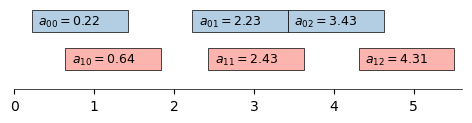

In [12]:
from mdp import SingleScheduleEnv, HorizonObservationWrapper, HorizonRollingWrapper
from mdp import visualize, draw_horizon_obs

i = generate_simple_instance()
visualize(i)

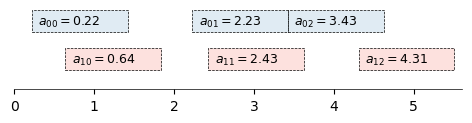

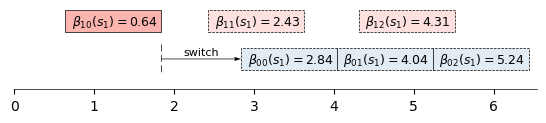

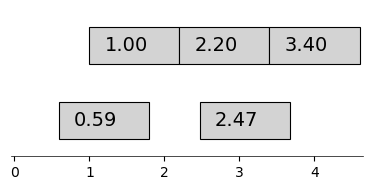

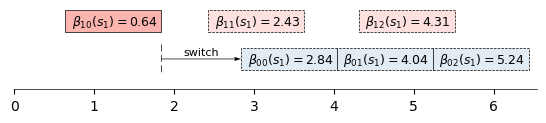

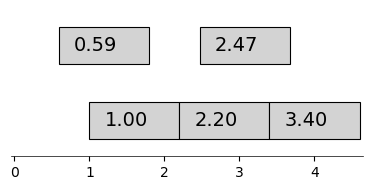

In [13]:
options = { 'render_roll': False }
normal_env = SingleScheduleEnv(instance_generator=lambda: i, options=options)
normal_env = HorizonObservationWrapper(normal_env)

cycle_env = SingleScheduleEnv(instance_generator=lambda: i, options=options)
cycle_env = HorizonObservationWrapper(cycle_env)
cycle_env = HorizonRollingWrapper(cycle_env)

h, _ = normal_env.reset()
h_cycled, _ = cycle_env.reset()

def render(h, h_cycled):
    normal_env.render()
    draw_horizon_obs(h)

    cycle_env.render()
    draw_horizon_obs(h_cycled)

normal_env.render() # initial state is the same anyway

h, *_ = normal_env.step(1)
h_cycled, *_ = cycle_env.step(1)

render(h, h_cycled)

In [14]:
h_cycled

{'horizon': array([[0.5889217, 2.4708447, 0.       ],
        [1.       , 2.2      , 3.4      ]], dtype=float32),
 'h_lengths': array([2, 3], dtype=int16)}

In [15]:
h

{'horizon': array([[1.       , 2.2      , 3.4      ],
        [0.5889217, 2.4708447, 0.       ]], dtype=float32),
 'h_lengths': array([3, 2], dtype=int16)}